In [1]:
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

import netron

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [2]:
original_dataset = pd.read_csv(r'..\..\datasets\data_sip.csv')
original_dataset.head()

,Task_ID,Priority,Project_ID,Project_code,Category,Total_developers,TaskPerformance,DeveloperPerformance,Hours_estimate,Hours_logged,Difference,Estimate_Effort
0,13728,1,10,PC10,Enhancement,1,6.47,6.47,28.0,21.53,6.47,4.568966
1,3530,1,9,PC9,Bug,1,6.46,6.46,7.0,0.54,6.46,1.853448
2,6163,1,9,PC9,Release,1,-6.45,-3.95,2.0,8.45,6.45,1.206897
3,6163,1,9,PC9,Release,1,-6.45,NaN,2.0,8.45,6.45,1.206897
4,11241,1,9,PC9,Enhancement,1,-6.38,-5.68,70.0,76.38,6.38,10.000000


In [3]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Task_ID               3937 non-null   int64  
 1   Priority              3937 non-null   int64  
 2   Project_ID            3937 non-null   int64  
 3   Project_code          3937 non-null   object 
 4   Category              3937 non-null   object 
 5   Total_developers      3937 non-null   int64  
 6   TaskPerformance       3937 non-null   float64
 7   DeveloperPerformance  3548 non-null   float64
 8   Hours_estimate        3937 non-null   float64
 9   Hours_logged          3937 non-null   float64
 10  Difference            3937 non-null   float64
 11  Estimate_Effort       3937 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 369.2+ KB


In [4]:
# drop all the unnecessary columns
clean_dataset = original_dataset[[
    'Priority',
    'Category',
    'Total_developers',
    'Estimate_Effort',
    'Hours_logged',
]]

# desnormalizing data
clean_dataset = pd.get_dummies(clean_dataset, columns=['Category'])
clean_dataset = clean_dataset.astype(int)

In [5]:
clean_dataset.head()

,Priority,Total_developers,Estimate_Effort,Hours_logged,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
0,1,1,4,21,0,1,0,0
1,1,1,1,0,1,0,0,0
2,1,1,1,8,0,0,1,0
3,1,1,1,8,0,0,1,0
4,1,1,10,76,0,1,0,0


In [6]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Priority              3937 non-null   int32
 1   Total_developers      3937 non-null   int32
 2   Estimate_Effort       3937 non-null   int32
 3   Hours_logged          3937 non-null   int32
 4   Category_Bug          3937 non-null   int32
 5   Category_Enhancement  3937 non-null   int32
 6   Category_Release      3937 non-null   int32
 7   Category_Testing      3937 non-null   int32
dtypes: int32(8)
memory usage: 123.2 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [7]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.20)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (3149, 8)
    Test: (394, 8)
    Validation: (394, 8)


### Data analysis

Calculate the correlation and other statistics on the train dataset

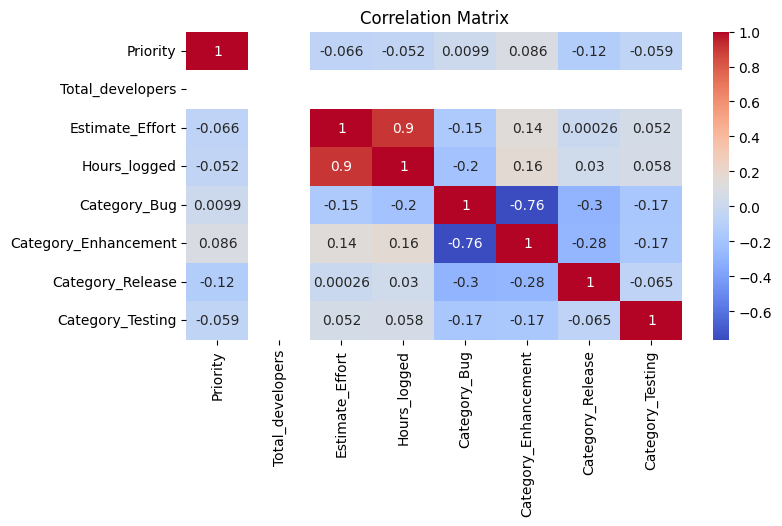

In [8]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours_logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# another interesting statistics like the count, mean, std, min, quartiles and max, all per feature
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Priority,3149.0,2.273420,1.768493,1.0,1.0,1.0,3.0,10.0
Total_developers,3149.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Estimate_Effort,3149.0,1.168307,0.714436,1.0,1.0,1.0,1.0,10.0
Category_Bug,3149.0,0.445538,0.497104,0.0,0.0,0.0,1.0,1.0
Category_Enhancement,3149.0,0.416323,0.493027,0.0,0.0,0.0,1.0,1.0
Category_Release,3149.0,0.099079,0.298816,0.0,0.0,0.0,0.0,1.0
Category_Testing,3149.0,0.039060,0.193769,0.0,0.0,0.0,0.0,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [10]:
train_label = train_dataset.pop('Hours_logged')
test_label = test_dataset.pop('Hours_logged')
validation_label = validation_dataset.pop('Hours_logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# is some of the data is NaN, fill it with 1
if normed_train_data['Total_developers'].isna().any():
    normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
    normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)
    normed_validation_data['Total_developers'] = normed_validation_data['Total_developers'].fillna(1)

In [12]:
# show a part of the normalized data
normed_train_data.head()

,Priority,Total_developers,Estimate_Effort,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
1991,-0.720059,1.0,-0.235581,-0.896268,1.183866,-0.331573,-0.201581
3165,0.410847,1.0,-0.235581,-0.896268,-0.844422,3.014973,-0.201581
200,-0.720059,1.0,-0.235581,1.115384,-0.844422,-0.331573,-0.201581
2613,-0.720059,1.0,-0.235581,1.115384,-0.844422,-0.331573,-0.201581
481,-0.720059,1.0,-0.235581,-0.896268,1.183866,-0.331573,-0.201581


## Building the Models

### Firts Model
Two hidden layers with 50 neurons each

In [13]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Input(shape=(normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

In [14]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Input(shape=(normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(128, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(32, Activation('relu'), name='hidden_layer_2'))
    
    
    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Third Model

LSTM Neural Network

In [15]:
def build_third_model_LSTM_hidden_layer():
    model = Sequential(name = "ThirdModelLSTMHiddenLayer")

    model.add(Input(shape=(normed_train_data.shape[1],)))

    model.add(Reshape((normed_train_data.shape[1], 1)))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(32, Activation('relu')))
  
    
    model.add(Dense(1))

    learnig_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model    

### Fourth Model

Support Vector Machine

In [16]:
def build_model_svc():
    parameters = {'kernel':('linear', 'rbf')}
    svr = SVR()
    return GridSearchCV(svr, parameters)

### Choose the model

In [17]:
def choose_model(model_type, model_number):
    if (model_type == 'Neuronal Network'):
        if (model_number == 1):
            return build_first_model_two_hidden_layers()
        elif (model_number == 2):
            return build_second_model_three_hidden_layers()
        elif (model_number == 3):
            return build_third_model_LSTM_hidden_layer()
    else:
        return build_model_svc()

Save checkpoints during training

In [20]:
checkpoint_path = r".\checkpoint_logs\data.weights.h5"

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', 
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
)

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)

## Model training

In [21]:
def training_neural_network_model(n_folds, model_number):
    kFold = KFold(n_splits=n_folds)

    histories = []

    i = 0

    for train_index, val_index in kFold.split(normed_train_data):
        train_data_i, val_data_i = normed_train_data.iloc[train_index], normed_train_data.iloc[val_index]
        train_label_i, val_label_i = train_label.iloc[train_index], train_label.iloc[val_index]


        # for first model - second place
        # epochs = 90
        # batch_size = 20

        # for second model - worst for now
        epochs = 80
        batch_size = 20

        # for third model - is winning
        # epochs = 150
        # batch_size = 80    

        model = choose_model('Neuronal Network', model_number)

        if i == 0:
            print("Summary of the model")
            model.summary()

        print("\n\nTraining the model - K Validation: ", i)

        history = model.fit(
            train_data_i,
            train_label_i,
            batch_size=batch_size,  
            epochs=epochs, 
            verbose=0,
            shuffle=True,
            steps_per_epoch = int(train_data_i.shape[0] / batch_size),
            validation_data=(val_data_i, val_label_i),
            callbacks=[
                tfdocs.modeling.EpochDots(),
                ckpt_callback,
            ]
        )

        histories.append(history)
        i = i + 1

    model = choose_model('Neuronal Network', model_number)
    model.load_weights(checkpoint_path)
    
    return model, histories

In [22]:
def training_support_vector_machine_model(n_folds):
    model = choose_model('Support Vector Machine', 0)
    scores = cross_val_score(model, normed_train_data, train_label, cv=n_folds)
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
    model.fit(normed_train_data, train_label)
    
    history = pd.DataFrame({
        'Accuracy': [model.score(normed_test_data, test_label)],
        'Best params hash': [model.best_params_],
        'Best score': [model.best_score_],
        'Best estimator': [model.best_estimator_],
    })

    print(history)
    return model, history

To run the NN model

In [23]:
%%time
model, histories = training_neural_network_model(n_folds=4, model_number=2)

Summary of the model


Model: "SecondModelThreeHiddenLayers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)



Training the model - K Validation:  0

Epoch: 0, accuracy:0.2042,  loss:61.8277,  mae:4.0144,  mse:61.8277,  val_accuracy:0.1802,  val_loss:42.1923,  val_mae:3.7605,  val_mse:42.7146,  
..

c:\Users\franc\anaconda3\envs\pasantia_ia\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


..............................................................................

Training the model - K Validation:  1

Epoch: 0, accuracy:0.2161,  loss:49.0968,  mae:3.6601,  mse:49.0968,  val_accuracy:0.2160,  val_loss:62.4689,  val_mae:3.5907,  val_mse:59.2232,  
................................................................................

Training the model - K Validation:  2

Epoch: 0, accuracy:0.2004,  loss:53.8479,  mae:3.8101,  mse:53.8479,  val_accuracy:0.2249,  val_loss:54.8075,  val_mae:3.5641,  val_mse:53.0460,  
................................................................................

Training the model - K Validation:  3

Epoch: 0, accuracy:0.2051,  loss:53.9077,  mae:3.7996,  mse:53.9077,  val_accuracy:0.2452,  val_loss:47.0261,  val_mae:3.3616,  val_mse:47.6861,  
................................................................................CPU times: total: 53.2 s
Wall time: 2min


c:\Users\franc\anaconda3\envs\pasantia_ia\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


To run the SVR model

In [73]:
%%time
model, history = training_support_vector_machine_model(n_folds=4)

Scores: [0.683599   0.75887118 0.79924887 0.77012018]
Mean: 0.7529598047150406
Standard deviation: 0.042670308945320784
   Accuracy      Best params hash  Best score        Best estimator
0  0.817596  {'kernel': 'linear'}    0.746547  SVR(kernel='linear')
CPU times: total: 13.8 s
Wall time: 21.2 s


## Predicting the data

### Predicted and real values

Here we will see the first 5 rows of the predicted data, comparing it with the real one

In [24]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)

print("Example for the first 5 samples")
print("Predicted Hours Logged")
print(example_result)
    
print("Real Hours Logged")
print(train_label[:5])

test_predictions = model.predict(normed_test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Example for the first 5 samples
Predicted Hours Logged
[[2.801646 ]
 [3.3385544]
 [1.9338565]
 [1.9338565]
 [2.801646 ]]
Real Hours Logged
1991     1
3165     1
200     11
2613     2
481     10
Name: Hours_logged, dtype: int32
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [25]:
test_predictions = model.predict(normed_test_data).flatten()

predictions_dataset = pd.DataFrame({
    'Logged': test_label,
    'Predicted': test_predictions
})

predictions_dataset_csv = predictions_dataset

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


To save histories from the NN model

In [26]:
predictions_dataset_csv.to_csv(r"./outputs/neural_network/predictions_sip.csv", index=False)

To save history from the SVR model

In [76]:
predictions_dataset_csv.to_csv(r"./outputs/svr/predictions_sip.csv", index=False)

Predictions VS. True Values for Hours Logged

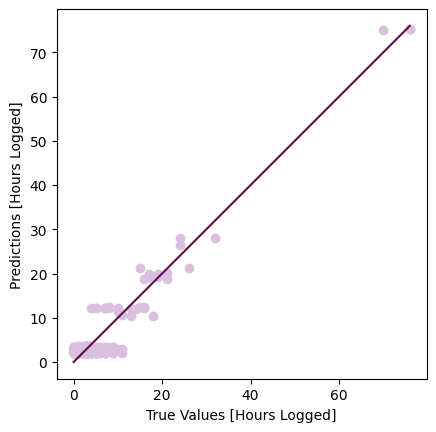

In [27]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions, color='#DBBFDF')
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value], color = '#5B0B4C')

To save prediction plot from the NN model

In [28]:
plt.savefig(r"./outputs/neural_network/prediction_plot_sip.png")

<Figure size 640x480 with 0 Axes>

To save prediction plot from the SVR model

In [78]:
plt.savefig(r"./outputs/svr/prediction_plot_sip.png")

<Figure size 640x480 with 0 Axes>

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Absolute Error** and **Mean Squarred Error**

### Showing the resulting metrics from the training

In [29]:
def evaluating_neural_network_model(histories):
    i = 0
    history_datasets = []
    for history in histories:
        history_dataset = pd.DataFrame(history.history)
        history_dataset['epoch'] = history.epoch
        history_dataset['fold'] = i
        i = i+1
        history_datasets.append(history_dataset)

        
    history_dataset = pd.concat(history_datasets)

    print("Resume of the training history model")
    display(HTML(history_dataset.tail(5).to_html()))

    history_datasets_csv = history_dataset
    history_datasets_csv.to_csv(r"./outputs/neural_network/history_sip.csv", index=False)  

    fold_histories = {
        f'Fold {i}': history for i, history in enumerate(histories)
    }

    print("Plotting the training history model per epoch")

    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot(fold_histories, metric="mse")
    plt.ylabel('MSE [Metric]')
    plt.show()

In [30]:
def evaluating_svc_model(history, test_predictions):
    history['MAE'] = [mean_absolute_error(test_label, test_predictions)]
    history['MSE'] = [mean_squared_error(test_label, test_predictions)]

    display(HTML(history.to_html()))

    history.to_csv(r"./outputs/svr/metrics_sip.csv", index=False)   

To evaluate the NN model

Resume of the training history model


,accuracy,loss,mae,mse,val_accuracy,val_loss,val_mae,val_mse,epoch,fold
75,0.000,4.167199,2.215162,8.334398,0.245235,7.089197,2.130913,7.126602,75,3
76,0.225,7.632055,2.135804,7.632052,0.245235,7.076721,2.121518,7.114554,76,3
77,0.000,4.172405,2.216271,8.344810,0.245235,7.083444,2.129132,7.120868,77,3
78,0.225,7.628850,2.135128,7.628848,0.245235,7.072805,2.121436,7.110595,78,3
79,0.000,4.167264,2.217144,8.334527,0.245235,7.079906,2.129249,7.117311,79,3


Plotting the training history model per epoch


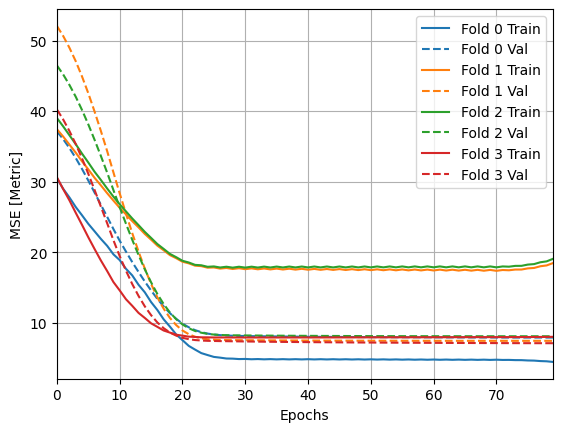

In [31]:
evaluating_neural_network_model(histories)

To evaluate the SVR model

In [32]:
evaluating_svc_model(history, test_predictions)

NameError: name 'history' is not defined

Only if the model is a NN

In [33]:
model.save(r"./outputs/neural_network/model_sip.keras")
netron.start(r"./outputs/neural_network/model_sip.keras")

Serving './outputs/neural_network/model_sip.keras' at http://localhost:8080


('localhost', 8080)